# Logística de envíos: ¿Cuándo llega?

## Mentoría DiploDatos 2019 

### Integrantes:

- Alini, Walter
- Frau, Johanna
- Salina, Noelia

### Mentora:

- Dal Lago, Virginia

### Práctico: Análisis y visualización de datos

# Indice


1. Motivación
2. Objetivos
3. Metodología
5. Lectura y análisis inicial de los datos, variables y datos anómalos o poco confiables
  1. Datos faltantes
  2. Análisis de shipment_days anómalos
  3. Análisis de fechas anómalas
  4. Dataset limpio
6. Estadísticos
7. Información extra
8. Análisis de los zipcodes, quantity y service
9. Análisis de Shipment Days
10. Análisis de probabilidad de envíos a Minas Gerais
11. Análisis de probabilidad de envíos por tipo
12. Análisis de correlación entre variables
13. Análisis de distancias
14. Análisis de la hora del día de entrega
15. Inferencia Bayesiana


## Motivación

En la actualidad, cada vez más productos se comercializan a través de una plataforma online. Una de las principales ventajas de este sistema es que el usuario puede recibir el producto en su domicilio en una fecha determinada. Pero, ¿cómo sabemos qué día va a llegar? ¿A partir de qué datos podemos predecir la demora del envío? En este práctico se trabajará con datos de envíos de MercadoLibre, el e-commerce más grande de Latinoamérica, analizando y modelando el problema de logística de envíos para poder responder ¿cuándo llega?

## Descripción del dataset

**Datos:**  El conjunto de datos seleccionado para realizar el práctico corresponde a un muestreo aleatorio no uniforme de 500.000 envíos de MercadoLibre. Estos envíos fueron realizados en Brasil en el período comprendido entre Octubre de 2018 y Abril de 2019 (las fechas originales han sido modificadas y adaptadas a un período de tiempo diferente, conservando el día de la semana y considerando los feriados correspondientes). Mientras que las fechas han sido modificadas, los horarios registrados en el dataset son los originales. Los datos comprenden variables tanto categóricas como numéricas. 

El dataset cuenta con las siguientes columnas:

- **Sender_state:** Estado de Brasil de donde sale el envío.
- **Sender_zipcode:** Código postal (de 5 dígitos) de donde sale el envío.
- **Receiver_state:** Estado de Brasil a donde llega el envío.
- **Receiver_zipcode:** Código postal (de 5 dígitos) a donde llega el envío.
- **Shipment_type:** Método de envío (normal, express, super).
- **Quantity:** Cantidad de productos en un envío.
- **Service:** Servicio del correo con el cual se realizó un envío.
- **Status:** Estado del envío (set: listo para ser enviado, sent: enviado, done: entregado, failed: no entregado, cancelled: cancelado).
- **Date_created:** Fecha de creación del envío.
- **Date_sent:** Fecha y hora en que se realizó el envío (salió del correo).
- **Date_visit:** Fecha y hora en que se entregó el envío al destinatario.
- **Shipment_days:** Días hábiles entre que el envío fue enviado (salió del correo) y que fue entregado.



## Objetivos



*   Aprender a leer y analizar el dataset para extraer información útil sobre el problema a resolver.
*  Ganar conocimiento en el manejo de librerías y metodologías de visualización para generar gráficas de los datos.
*   Calcular estadísticos que faciliten, junto a los gráficos, dar respuestas a preguntas propias de la problemática.
*   Desarrollar habilidades de comunicación de la información obtenida a partir de los datos de manera clara y sencilla.


## Metodología

A lo largo de este trabajo trataremos de responder a las siguientes preguntas:

1. ¿Qué tipo de variables se encuentran presentes en el dataset? Realizar una breve descripción estadística de las mismas, determinar si existen outliers y valores incorrectos o no esperados.
1. ¿Cómo es la distribución de zipcodes de origen y destino de un envío? ¿Está concentrada en algún valor? ¿Y para el resto de las variables?
2. ¿Es la distribución del número de días que demora un envío normal? ¿Adquiere significado la media y desviación estándar? ¿Qué tipo de estadísticos podrían ser relevantes en este caso? ¿Hay alguna otra distribución a la cual se asemeje más?
3. ¿Cuál es la probabilidad de que el destinatario de un envío sea del estado de Minas Gerais (MG)? ¿Cuál es la probabilidad de que dicho envío (que llega a Minas Gerais) sea realizado mediante el servicio 1? 
4. ¿Cuál es la probabilidad de que un envío sea realizado con el método super express? ¿Y la de que un envío realizado con dicho método llegue al estado de Minas Gerais?
5. ¿Existe correlación entre el número de días que tarda un envío y el destinatario del mismo? ¿Y entre el número de días y la cantidad de productos en un paquete? ¿Con qué otra variable está correlacionado el número de días que tarda un envío? Analizar la independencia de las variables.
6. Además del cálculo de los estadísticos correspondientes, sería interesante observar un gráfico que muestre la información estadística (por ejemplo, la media) y la presencia de outliers del número de días que tardan los envíos que se realizan a los diferentes estados de Brasil. ¿Cuál es el estado que, en promedio, tiene una mayor demora?
7. ¿Cuál es la distancia geográfica de San Pablo a dicho estado? ¿Y al de menor?
8. ¿Cuál es la distribución de la entrega de envíos por hora del día para cada uno de los estados de Brasil? Realizar un único gráfico donde se muestre esta información.
7. Bonus (no obligatorio): Proponer y discutir la aplicación de al menos uno de los contenidos desarrollados en la clase de “Inferencia Bayesiana” al conjunto de datos y problemática aquí presentada. 

## Lectura y análisis inicial de los datos, variables y datos anómalos o poco confiables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy import special

BLUE = '#35A7FF'
RED = '#FF5964'
GREEN = '#6BF178'
YELLOW = '#FFE74C'

Leemos el dataset y vemos cuántas entradas y variables tiene. Notar que estamos usando información de contexto para leer esta información con los tipos que corresponden:

In [2]:
ds = pd.read_csv('dataset_sample_corrected.csv', 
                       dtype={'sender_zipcode':'int64',
                              'receiver_zipcode':'int64',
                              'quantity':'int64',
                              'service':'int64'},
                       parse_dates=['date_created','date_sent','date_visit'])
rows, cols = ds.shape
print (rows, cols)

500000 12


Contamos con 500.000 entradas y 12 columnas o variables con información. Veamos cuáles son:

In [3]:
ds.columns

Index(['sender_state', 'sender_zipcode', 'receiver_state', 'receiver_zipcode',
       'shipment_type', 'quantity', 'service', 'status', 'date_created',
       'date_sent', 'date_visit', 'shipment_days'],
      dtype='object')

Veamos un poco más de información de las variables en juego (***Pregunta n°1***):

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 12 columns):
sender_state        500000 non-null object
sender_zipcode      500000 non-null int64
receiver_state      500000 non-null object
receiver_zipcode    500000 non-null int64
shipment_type       500000 non-null object
quantity            500000 non-null int64
service             500000 non-null int64
status              500000 non-null object
date_created        500000 non-null datetime64[ns]
date_sent           499971 non-null datetime64[ns]
date_visit          499398 non-null datetime64[ns]
shipment_days       499398 non-null float64
dtypes: datetime64[ns](3), float64(1), int64(4), object(4)
memory usage: 45.8+ MB


Los resultados de arriba comprueban la información inicial proporcionada que nos decía que tenemos columnas numéricas, categóricas y con información de fechas y horas de los envíos.

**Variables numéricas**

1. sender_zipcode
2. receiver_zipcode
3. quantity
4. service
5. shipment_days


**Variables categóricas**

1. sender_state
2. receiver_state
3. shipment_type
4. status	

**Variables de fecha**

1. date_created	
2. date_sent
3. date_visit


Veamos un pantallazo general de algunos estadísticos de la información, empezando por las columnas numéricas:

In [5]:
ds.describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,500000.000000,500000.000000,500000.000000,500000.000000,499398.000000
mean,8305.328412,39982.634918,1.278192,1.515708,5.367969
std,5088.259017,30975.031692,0.661639,1.826306,5.024451
min,1001.000000,1001.000000,1.000000,0.000000,-77.000000
25%,3673.000000,13140.000000,1.000000,0.000000,2.000000
50%,7274.000000,31150.000000,1.000000,1.000000,4.000000
75%,13277.000000,70670.000000,1.000000,2.000000,8.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


Algunas observaciones:

* Encontramos al menos un valor anómalo en la columna **shipment_days** (el **-77** ). Dicha columna no puede tomar valores negativos pues representa la cantidad de días hábiles entre envío y recepción del producto. En la misma columna observamos 602 datos faltantes (0.1204%).

* La variable **service** posee 13 servicios de correo diferentes (siendo el primero el más frecuente). 

* La variable **quantity** además  tiene un mínimo de 1 item y un máximo de 5 por envío (donde el más frecuente es un item por envío).

* Estadísticos como la media, desviación estándar o la varianza en las variables **sender_zipcode**, **sender_receiver** y **service** no son muy útiles en este caso pues si bien son variables numéricas representan categorías y su significado va más alla de su ordenamiento numérico. Sin embargo, es posible que en el caso de los zipcodes su ordenamiento o distribución nos de información acerca de como funcionan los envíos/recepciones por estados o regiones.

Sigamos por las variables de datos con información no numérica (o de fecha):

In [6]:
ds.describe(include='object')

,sender_state,receiver_state,shipment_type,status
count,500000,500000,500000,500000
unique,1,27,3,5
top,SP,SP,standard,done
freq,500000,190586,263227,494983


**Algunas observaciones**

* Las columnas categóricas no tienen datos faltantes.
* Sólo se realizan envíos desde SP.
* Hay 27 estados destino diferentes siendo el más frecuente SP.
* Hay 3 tipos de envío diferentes siendo el más frecuente el standard, el cual tiene más de la mitad de los datos totales.
* Hay 5 "situaciones" de envío (para diferenciar **status** de "state") siendo la más frecuente "done", donde dicha frecuencia se acerca mucho a la cantidad total de los datos.

Finalmente, un pantallazo de las columnas de fechas:




In [7]:
ds.describe(include='datetime64')

,date_created,date_sent,date_visit
count,500000,499971,499398
unique,150,81391,55669
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20456,113,621
first,2018-09-06 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-07-01 00:00:00,2019-07-01 18:01:55,2019-04-02 15:35:00



**Observaciones**

* La variables **created_date** solo tiene 150 valores distintos y no considera fechas (todas están seteadas a las 00:00 hs) esto implica que estamos considerando un total de 150 días distintos.
* La variable anterior, **date_created** y **date_sent** contienen fechas que caen fuera del intervalo temporal considerado y más aún, que hasta el momento de este informe, representa una fecha futura (Julio de 2019).
* Hay mucha diferencia entre los mínimos de las 3 fechas, podría servir analizar los estados de las fechas fuera del periodo de **date_visit** para ver si no son anómalos.
* Faltan 29 datos en **date_sent** (0.0058%) y 602 datos en **date_visit** (0.1204%).
* En la variable **date_visit** el dato más frecuente se da a las 22.00 hs, posiblemente fuera del horario de atención de los correos, con lo cual este dato es bastante extraño en un principio. Lo mismo sucede con el horario 05:36.


**Algunas preguntas que surgen de este análisis son:**

1. ¿Es posible que el correo haga su visita en horarios como las 22.00 o a las 05:36 hs? ¿O qué un pedido salga del correo a las 18hs?

2. ¿Los registros de horarios son útiles para nuestro análisis o debemos dejarlos de lado y considerar solo las fechas?

3. ¿Podemos considerar a los registros de **data_created**  más precisos que los de **data_sent** y **data_visit**?

4. ¿Nos dice algo el número de frecuencia de estas tres variables?

Más adelante volveremos sobre estas preguntas.




A continuación inspeccionemos algunas filas al azar de nuestro dataset:

In [8]:
# Por cuestiones de reproducibilidad (y sólo como valor para este informe),
# establecemos la semilla del generador de aleatoriedad
np.random.seed(0)
ds.sample(10)

,sender_state,sender_zipcode,receiver_state,receiver_zipcode,shipment_type,quantity,service,status,date_created,date_sent,date_visit,shipment_days
194257,SP,3734,RS,96540,standard,1,4,done,2019-02-17,2019-02-22 03:49:21,2019-03-07 15:09:00,6.0
396319,SP,6422,SP,9580,express,1,5,done,2019-03-04,2019-03-07 20:24:02,2019-03-07 10:02:09,0.0
138738,SP,14940,CE,62650,standard,1,1,done,2019-02-08,2019-02-13 13:51:00,2019-03-11 14:16:00,15.0
66570,SP,1004,MG,32340,express,1,4,done,2019-03-16,2019-03-19 00:52:07,2019-03-25 19:00:00,4.0
149424,SP,13254,BA,44700,express,1,0,done,2019-03-02,2019-03-04 15:41:00,2019-03-12 15:19:00,3.0
128165,SP,9850,SP,12301,express,2,0,done,2019-03-17,2019-03-19 13:39:00,2019-03-20 18:59:00,1.0
264495,SP,3627,BA,44690,standard,1,1,done,2019-03-04,2019-03-06 12:13:00,2019-03-22 14:17:00,11.0
30371,SP,13456,SP,5268,express,2,0,done,2019-03-12,2019-03-13 15:07:00,2019-03-14 16:26:00,1.0
456998,SP,3004,SC,89300,standard,1,3,done,2019-02-15,2019-02-17 04:52:00,2019-03-07 17:56:00,10.0
32001,SP,19013,SP,14815,standard,2,1,done,2019-03-21,2019-03-22 14:32:00,2019-03-26 13:39:00,2.0


## Datos faltantes

Siempre que analizamos un conjunto de datos es interesante conocer la cantidad real de los datos con los que estamos trabajando. Este problema es equivalente a calcular la cantidad de datos faltantes. Estas cantidades pueden inferir en nuestras conclusiones y en el valor real del análisis.

Sabemos que nuestro dataset contiene 500.00 filas y 12 columnas, lo cual nos da un total de 6.000.000 de datos:

In [9]:
# Datos faltantes o nulos
null = ds.isnull()

# Cantidad de nulos por columna
n_null_by_column = null.sum()

# Cantidad de nulos total en el dataset
n_null = n_null_by_column.sum()
n_null

1233

Tenemos 1233 datos faltantes. Si lo comparamos con la cantidad total (6.000.000 ) este número puede resultar no significativo. Sin embargo. consideramos que es muy temprano para hacer esta suposición pues los datos podrían pertenecer todos a una misma columna y esto podría en consecuencia afectar el análisis. 

## Análisis de shipment_days anómalos


In [10]:
m_shipment_days_negative = ds.shipment_days < 0 #Filtramos la columna shipment_days para encontrar los valores negativos
m_shipment_days_positive = ds.shipment_days >= 0 #Hacemos lo mismo para los shipment_positivos
#Analizamos los estadísticos para los valores negativos de shipment_days
ds[m_shipment_days_negative].describe() 

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,48.00000,48.000000,48.000000,48.000000,48.000000
mean,6933.50000,31424.875000,1.354167,6.770833,-61.083333
std,4507.20175,32577.232988,0.729021,2.398932,21.236093
min,1133.00000,1021.000000,1.000000,2.000000,-77.000000
25%,3111.25000,4705.000000,1.000000,4.000000,-77.000000
50%,6422.00000,18201.000000,1.000000,7.000000,-74.000000
75%,9140.00000,53934.250000,1.000000,9.000000,-37.000000
max,18070.00000,95300.000000,4.000000,9.000000,-5.000000


In [11]:
ds[m_shipment_days_negative].describe(include='object')

,sender_state,receiver_state,shipment_type,status
count,48,48,48,48
unique,1,12,2,2
top,SP,SP,express,done
freq,48,26,27,43


In [12]:
ds[m_shipment_days_negative].describe(include='datetime64')

,date_created,date_sent,date_visit
count,48,48,48
unique,25,39,47
top,2019-06-28 00:00:00,2019-07-01 14:48:20,2019-03-01 12:51:00
freq,9,4,2
first,2019-03-08 00:00:00,2019-03-12 23:22:53,2019-02-28 14:21:00
last,2019-07-01 00:00:00,2019-07-01 18:01:55,2019-03-12 15:44:00


Observaciones:

* -77 no es el único valor anómalo
* Hay 48 de 500.000 (0.0096%) registros afectados

Dado que este porcentaje es mínimo, podría ser apropiado descartarlos. 

## Análisis de fechas anómalas

Las 3 variables de fechas que tenemos en este dataset, y los supuestos que proponemos para ellas, son:

- **date_created**: Corresponde a la fecha de creación del envío.
  - Es una fecha que se crea automáticamente a través de algunos de los procesos de venta de MercadoLibre.
  - Sólo nos interesa la fecha y no la hora de creación.
- **date_sent**: Corresponde a la fecha y hora en que alguno de los correos cargó para el envío en cuestión, que comenzó el proceso de envío.
 - Consideraremos **date_sent** como la fecha en que el envío está a cargo del correo y no necesariamente cuando el envío "salió" del correo (más bien cuando "entró" al correo, que es cuando el proceso de handling llega a su fin).
 - Puede crearse "automáticamente" cuando el vendedor deja el contenido del envío en el correo.
  - Puede también crearse "manualmente", pensando en lugares de recepción de correos sin la tecnología suficiente para que esta fecha sea generada automáticamente. Es posible entonces que sea necesario "aceptar" algunas fechas no precisas como válidas.
 * Por los supuestos en **date_created** y las anteriores para **date_sent**, esta fecha debe necesariamente ser posterior a **date_created**
- **date_visit**: Corresponde a la fecha y hora en que alguno de los correos cargó en envío en cuestión como entregado.
  - Puede crearse "automáticamente" cuando el cartero utiliza tecnología (lector de código de barras o aplicación movil, por ejemplo).
  - Puede crearse "manualmente", pensando en que el cartero, al terminar un ciclo o jornada, provee de la información de todos los envíos entregados en ese ciclo o jornada.
  - Por los supuestos en **date_created**, **date_sent** y los anteriores de **date_visit**, esta fecha debe neceariamente ser posterior a **date_created**. Se espera también que sea posterior a **date_sent** también, pero deberemos tomar una decisión en estos casos en función de análisis del dataset.

In [13]:
m_date_created_after_date_sent = (ds.date_created >= ds.date_sent) #Filtramos date_created mayores que date_sent
m_date_created_before_date_sent = (ds.date_created < ds.date_sent) #Filtramos date_created menores que date_sent

m_date_created_after_date_visit = (ds.date_created >= ds.date_visit) #Filtramos date_created mayores que date_visit
m_date_created_before_date_visit = (ds.date_created < ds.date_visit) #Filtramos date_created menores que date_visit

m_date_created_invalid = m_date_created_after_date_sent | m_date_created_after_date_visit #Fechas de creación anomalas

ds[m_date_created_invalid].describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,194.000000,194.000000,194.000000,194.000000,179.000000
mean,7733.309278,41872.061856,1.237113,5.969072,-8.508380
std,4884.848489,30855.877916,0.589602,1.862939,34.751828
min,1039.000000,1021.000000,1.000000,2.000000,-77.000000
25%,3120.750000,13930.000000,1.000000,4.000000,-32.500000
50%,7411.000000,29108.500000,1.000000,7.000000,0.000000
75%,9961.000000,71970.500000,1.000000,7.000000,17.000000
max,19160.000000,97502.000000,4.000000,10.000000,38.000000


Tenemos 194 casos donde **date_created** no sigue los supuestos planteados. Por lo tanto, consideramos que esta información anómala o no válida debe ser eliminada del dataset.

In [14]:
m_date_sent_after_date_visit = ds.date_sent >= ds.date_visit #Filtramos date_sent mayores que date_visit
m_date_sent_before_date_visit = ds.date_sent < ds.date_visit #Filtramos date_sent menores que date_visit

ds[m_date_sent_after_date_visit].describe()

,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,2407.000000,2407.000000,2407.000000,2407.000000,2407.000000
mean,7066.651849,12403.598671,1.283756,2.230577,-1.218114
std,4860.648858,17464.272237,0.670354,2.867468,9.042260
min,1001.000000,1005.000000,1.000000,0.000000,-77.000000
25%,3026.000000,4107.500000,1.000000,0.000000,0.000000
50%,5373.000000,6663.000000,1.000000,0.000000,0.000000
75%,11017.500000,13214.000000,1.000000,5.000000,0.000000
max,19970.000000,95300.000000,5.000000,10.000000,0.000000


Tenemos 2407 casos en donde se consignó que el paquete entró al proceso de envío después de la fecha de consignación de llegada. No representan una cantidad significativa de casos como para analizar si tiene sentido sacarlos o dejarlos del dataset, por lo que consideramos que es información no confiable que podemos quitar.

## Dataset limpio

Generaremos un nuevo dataset sin:
 - Anomalías y nulos en **shipment_days**.
 - Anomalías y nulos en **date_created**, **date_sent** y **date_visit**.

In [15]:
# Generate a new, cleaned dataset
dataset = ds[m_shipment_days_positive].dropna() # solo shipment_days positives
dataset = dataset[m_date_created_before_date_sent].dropna() # solo fechas de creacion antes de la fecha de envio
dataset = dataset[m_date_created_before_date_visit].dropna()# solo fechas de creacion antes de la fecha de visita
dataset = dataset[m_date_sent_before_date_visit].dropna()# solo fechas de envios antes de la fecha de visita
dataset.to_csv("data_sample_corrected_cleaned.csv", sep=',', index=False)
dataset.describe()

/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/nsalina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,sender_zipcode,receiver_zipcode,quantity,service,shipment_days
count,496860.000000,496860.000000,496860.000000,496860.000000,496860.000000
mean,8311.897045,40109.041430,1.278213,1.509465,5.398454
std,5088.813901,30969.204018,0.661664,1.817370,4.973359
min,1001.000000,1001.000000,1.000000,0.000000,0.000000
25%,3680.000000,13172.000000,1.000000,0.000000,2.000000
50%,7400.000000,31340.000000,1.000000,1.000000,4.000000
75%,13283.000000,70719.000000,1.000000,2.000000,8.000000
max,19970.000000,99990.000000,5.000000,12.000000,90.000000


In [16]:
dataset['service'].unique().size #dataset limpio

12

In [17]:
ds['service'].unique().size #dataset original

13

## Estadísticos


**Shipment _days**

* El valor medio de envío es 5.39 días
* La desviación estándar es 4.97 días.
* La mediana es 4 días
* El rango es de 90 días
* El 50% de los envíos demora entre 0 y 4 días
* El 75% de los envíos demora entre 0 y 8 días


**Quantity**

* El valor medio es de 1.27 productos por envío.
* La desviación estándar de esta variable es 0.66
* La mediana es 1 producto por envío
* El rango es de 5 productos
* El 75% de los envíos lleva sólo un producto

In [18]:
dataset.describe(include='object') #dataset limpio

,sender_state,receiver_state,shipment_type,status
count,496860,496860,496860,496860
unique,1,27,3,2
top,SP,SP,standard,done
freq,496860,188266,262721,492495


In [19]:
ds.describe(include='object') #Dataset original

,sender_state,receiver_state,shipment_type,status
count,500000,500000,500000,500000
unique,1,27,3,5
top,SP,SP,standard,done
freq,500000,190586,263227,494983


In [20]:
dataset.describe(include='datetime64')

,date_created,date_sent,date_visit
count,496860,496860,496860
unique,108,81083,54951
top,2019-03-05 00:00:00,2019-03-11 15:53:00,2019-03-11 22:00:00
freq,20048,113,621
first,2018-10-21 00:00:00,2018-10-23 13:57:00,2019-02-25 05:36:00
last,2019-03-28 00:00:00,2019-03-29 01:46:20,2019-04-02 15:35:00


In [21]:
dataset['status'].unique() #Dataset limpio (variable status)

array(['done', 'failed'], dtype=object)

In [22]:
ds['status'].unique() #Dataset original (variable status)

array(['done', 'failed', 'sent', 'cancelled', 'set'], dtype=object)

La limpieza de nuestro dataset tuvo las siguientes consecuencias:

* Hay 12 servicios de correo donde el más frecuente es el 1 (antes eran 13).
* Hay 2 estados de envío (_done_ y _failed_) donde el más frecuente es _done_. Los otros 3 valores que puede tomar esta variable (_set_, _failed_ y _cancelled_) no tenían valor en **shipment_days** ante la falta de **date_visit**. Consideramos que estos valores no son de interés para nuestra problemática. 

## 2. Información extra

En función de la información que tenemos y la información que nos gustaría revisar, generamos otro dataset con información de los estados de Brasil, con los siguientes campos:

- **id**: Dos letras que determinan unívocamente el estado (como lo tenemos en el dataset de la problemática)
- **name**: Nombre del estado
- **name_mapchart**: Nombre del estado tal cual lo necesita https://paintmaps.com/map-charts/29/Brazil-map-chart (por si hace falta usarlo para graficar)
- **lat**: Latitud (de su capital, como figura en http://www.distancelatlong.com/country/brazil)
- **lon**: Longitud (de su capital, como figura en http://www.distancelatlong.com/country/brazil)
- **zipfrom1**: Inicio del segmento1 de los Código Postales del estado, acortado a los primeros 5 dígitos, como tenemos en la problemática (como figura en https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil)
- **zipto1**: Fin del segmento1 de los Código Postales del estado, acortado a los primeros 5 dígitos, como tenemos en la problemática (como figura en https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil)
- **zipfrom2**: (opcional) Inicio del segmento1 de los Código Postales del estado, acortado a los primeros 5 dígitos, como tenemos en la problemática (como figura en https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil)
- **zipto2**: (opcional) Fin del segmento1 de los Código Postales del estado, acortado a los primeros 5 dígitos, como tenemos en la problemática (como figura en https://en.wikipedia.org/wiki/List_of_postal_codes_in_Brazil)
- **distance**: Distancia a Sao Paulo (en Km), usando latitud y longitud de este mismo dataset, y de acuerdo a lo que devuelve https://www.movable-type.co.uk/scripts/latlong.html


In [23]:
brazil_states = pd.read_csv('states_info.csv', delimiter=';',
                           dtype={'lat':'float64',
                                  'lon':'float64'})
brazil_states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 10 columns):
id               27 non-null object
name             27 non-null object
name_mapchart    27 non-null object
lat              27 non-null float64
lon              27 non-null float64
zipfrom1         27 non-null int64
zipto1           27 non-null int64
zipfrom2         5 non-null float64
zipto2           5 non-null float64
distance         27 non-null int64
dtypes: float64(4), int64(3), object(3)
memory usage: 2.2+ KB


In [ ]:
brazil_states

,id,name,name_mapchart,lat,lon,zipfrom1,zipto1,zipfrom2,zipto2,distance
0,AC,Acre,Acre,-9.070003,-68.669979,69900,69999,NaN,NaN,2862
1,AL,Alagoas,Alagoas,-9.480004,-35.839968,57000,57999,NaN,NaN,2864
2,AP,Amapa,Amapá,-0.039598,-51.179987,68900,68999,NaN,NaN,2682
3,AM,Amazonas,Amazonas,-3.289581,-60.619980,69000,69299,69400.0,69899.0,2731
4,BA,Bahia,Bahia,-16.280002,-39.029980,40000,48999,NaN,NaN,1140
5,CE,Ceara,Ceará,-2.899992,-40.850024,60000,63999,NaN,NaN,2396
6,DF,Distrito Federal,Distrito_Federal,-15.783340,-47.916052,70000,72799,73000.0,73699.0,896
7,ES,Espirito Santo,Espírito_Santo,-20.850008,-41.129981,29000,29999,NaN,NaN,641
8,GO,Goias,Goiás,-17.730043,-49.109985,72800,72999,73700.0,76799.0,719
9,MA,Maranhao,Maranhão,-5.809996,-46.149984,65000,65999,NaN,NaN,1994


## 3. Análisis de los zipcodes, quantity y service

En esta sección intentaremos responder las siguientes preguntas (**Pregunta n°2** ):

¿Cómo es la distribución de zipcodes de origen y destino de un envío? ¿Está concentrada en algún valor? ¿Y para el resto de las variables?

A continuación mostramos los histogramas de las variables **sender_zipcode** y **receiver_zipcode**  respectivamente. Consideramos que dichos histogramas en sí no nos brindan demasiada información sobre todo en **receiver_zipcode** donde estamos considerando casi 19.000 códigos distintos lo cual puede apreciarse en la variabilidad de su histograma (no muestra ninguna tendencia marcada). 

Por otro lado, dado que todos los envíos salen de San Pablo no tiene sentido hacer un estudio por estados en la variable **sender_zipcode** pero quizás si lo tiene en el caso de **receiver_zipcode** donde tenemos más margen para investigar pues los envíos llegan a diferentes estados. Las diferentes concentraciones de este histograma quizás podrían estar relacionadas con el envío a  estados diferentes (en el gráfico hay tres picos marcados).

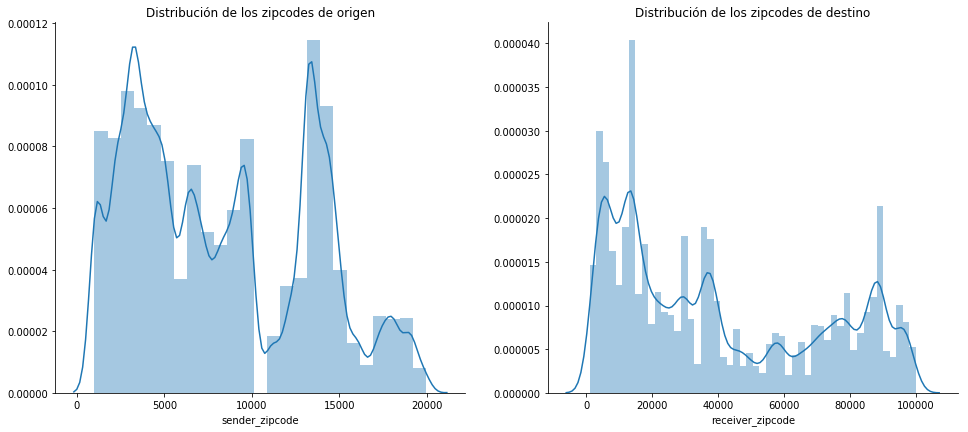

In [ ]:
plt.figure(figsize=(25,15))
plt.subplot2grid((2,3),(0,0))
sns.distplot(dataset['sender_zipcode'].dropna(), bins=25)
plt.title('Distribución de los zipcodes de origen')
plt.subplot2grid((2,3),(0,1))
sns.distplot(dataset['receiver_zipcode'].dropna(), bins=50)
plt.title('Distribución de los zipcodes de destino')

sns.despine()


In [ ]:
dataset['receiver_zipcode'].unique().size # Cantidad de códigos postales distintos de la variable receiver_zipcode

18909

In [ ]:
dataset['sender_zipcode'].unique().size #Cantidad de códigos postales distintos de la variable sender_zipcode

5450

In [ ]:
dataset['receiver_state'].unique().size

27

Los códigos postales de Brasil tienen 8 números, con la forma:

abcde-fgh

Donde, por lo general:

* a: Región
* b: Sub Región
* c: Sector
* d: Sub Sector
* e: Sub Sector del divisor
* fgh: Zona de entrega

Sabiendo que los datos fueron modificados para que tengan una longitud de 5 dígitos, y con un pequeño análisis de los códigos postales de Brasil, sabemos que los 5 dígitos con los que contamos en el dataset corresponden a los dígitos que no incluyen la determinación de la zona de entrega. Con lo cual, concluimos que a priori no estaríamos perdiendo información que consideremos de valor para el análisis de la problemática. O en todo caso, podemos contar con que la información de CP de envío y destino es lo suficientemente precisa para que no afecte el análisis que queremos realizar.

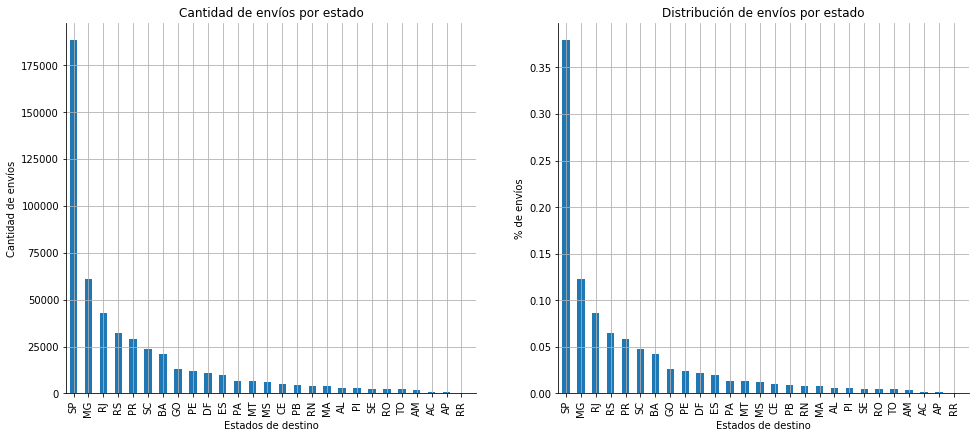

In [ ]:
plt.figure(figsize=(25,15))
plt.subplot2grid((2,3),(0,0))
ax = dataset['receiver_state'].value_counts(normalize=False,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Cantidad de envíos por estado')
ax.set(xlabel="Estados de destino",ylabel="Cantidad de envíos")
plt.xlim(-0.5,27)

plt.subplot2grid((2,3),(0,1))
ax = dataset['receiver_state'].value_counts(normalize=True,
                                       dropna=True,
                                       sort=True).plot(kind='bar',
                                                       grid=True)
plt.title('Distribución de envíos por estado')
ax.set(xlabel="Estados de destino",ylabel="% de envíos")
plt.xlim(-0.5,27)
sns.despine()
sns.despine()

El gráfico de barras anterior muestra, como habíamos notado en el primer punto de este trabajo, que el estado de San Pablo es el que recibe más envíos, seguido por Minas Gerais y Río de Janeiro. Probablemente los picos que observamos en el histograma de la variable **receiver_zipcode** sean estos tres estados.

A continuación mostramos la distribución de las variables **quantity** y **service**.

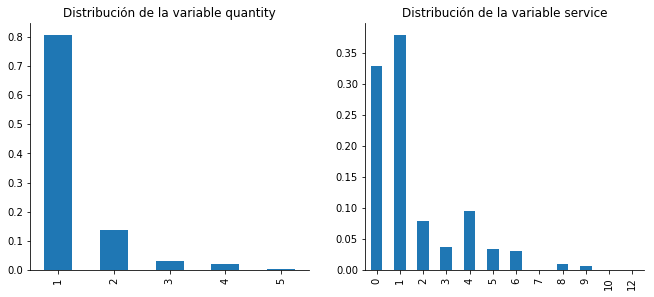

In [ ]:
plt.figure(figsize=(23,10))

plt.subplot2grid((2,4),(0,0))
dataset['quantity'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribución de la variable quantity')

plt.subplot2grid((2,4),(0,1))
dataset['service'].value_counts(normalize=True,sort=False).plot(kind='bar')
plt.title('Distribución de la variable service')
sns.despine()

**Quantity**

* El 80% de los envíos contiene un único producto.
* El 20% restante tiene como máxima la cantidad 2 y muy por debajo se encuentran las cantidades 3, 4 y 5.

Es muy poco frecuente en el envío de más de un producto. Sobre esta variable no se puede suponer demasiado ya que si los múltiples productos son enviados en un mismo paquete, la información de quantity podría ser despreciable. Sería interesante verificar que no tiene correlación con el resto de las variables.

**Service**

* Los servicios de correo están concentrados en el 0 y 1, que abarcan el 70% de los envíos.

Sería interesante verificar si la mayoría de envíos en los servicios 0 y 1 tienen también un menor tiempo de entrega ya que se puede suponer que podrían tener mayor y mejor cobertura. Por el contrario, se podría verificar si los envíos de los servicios minoritarios tienen un incremento de similares proporciones sobre sus tiempos de entrega. En este caso también resultaría de interés ver la correlación entre esta variable y el tiempo de envío. Si ésta correlación se valida, esta variable podría tener un alto contenido de información para predecir cuándo llegará un envío.

A simple vista, se puede observar que la concentración de valores de las variables muestra una distribución que se asemeja a una exponencial (o Poisson), ya que la mayor concentración se da para unos pocos valores.

## 4. Análisis de Shipment Days

En esta sección intentaremos responder a las siguientes preguntas (**Pregunta n° 3**):

¿Es la distribución del número de días que demora un envío normal? ¿Adquiere significado la media y desviación estándar? ¿Qué tipo de estadísticos podrían ser relevantes en este caso? ¿Hay alguna otra distribución a la cual se asemeje más?


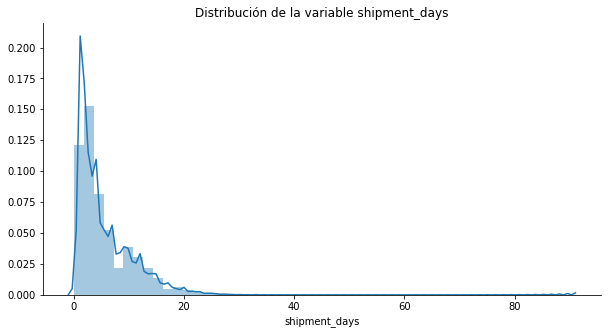

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(dataset['shipment_days'].dropna(), bins=50)
plt.title('Distribución de la variable shipment_days')
sns.despine()

In [ ]:
dataset['shipment_days'].describe(percentiles=[x/10 for x in range(11)])

count    496860.000000
mean          5.398454
std           4.973359
min           0.000000
0%            0.000000
10%           1.000000
20%           1.000000
30%           2.000000
40%           3.000000
50%           4.000000
60%           5.000000
70%           7.000000
80%           9.000000
90%          13.000000
100%         90.000000
max          90.000000
Name: shipment_days, dtype: float64

* El 60% de los envíos llega en 5 días o menos
* El 90% de los envíos llega en 13 días o menos

La variable **shipment_days** no muestra una distribución normal de acuerdo al histograma visto anteriormente. Esta variable podría seguir la forma de una distribución de Poisson. La línea continua que se observa representa la función de distribución que mejor se aproxima a nuestros datos (los cuales están divididos en bines). De acuerdo a los contextos esta función puede resultar más o menos útil. En nuestro caso solo queremos saber que forma tienen nuestros datos, no encontrar dicha función.

## 5. Análisis de probabilidad de envíos a Minas Gerais

En esta sección intentaremos responder los siguientes interrogantes: (**Pregunta n°4**)

¿Cuál es la probabilidad de que el destinatario de un envío sea del estado de Minas Gerais (MG)? ¿Cuál es la probabilidad de que dicho envío (que llega a Minas Gerais) sea realizado mediante el servicio 1? 


A continuación calcularemos los porcentajes de envíos llegan a cada estado.

In [ ]:
dataset['receiver_state'].value_counts(normalize=True)

SP    0.378912
MG    0.122364
RJ    0.085907
RS    0.065316
PR    0.058018
SC    0.047746
BA    0.042459
GO    0.026637
PE    0.024103
DF    0.021801
ES    0.020243
PA    0.013048
MT    0.012953
MS    0.011907
CE    0.010510
PB    0.008940
RN    0.008113
MA    0.007519
AL    0.006006
PI    0.005497
SE    0.005168
RO    0.004508
TO    0.004245
AM    0.003931
AC    0.001683
AP    0.001582
RR    0.000884
Name: receiver_state, dtype: float64

La probabilidad de que un envío tenga como destino al estado de Mina Gerais es el **12.23%** .

In [ ]:
dataset[dataset.receiver_state == 'MG']['service'].value_counts(normalize=True)

1     0.531580
0     0.163640
2     0.126320
4     0.119182
6     0.034442
3     0.022303
9     0.001431
7     0.001069
10    0.000033
Name: service, dtype: float64

La probabilidad de que un envío a Minas Gerais sea realizado con el servicio de correo 1 es **53.15%**.



## 6. Análisis de probabilidad de envíos por tipo

En esta sección intentaremos responder las siguientes preguntas:

¿Cuál es la probabilidad de que un envío sea realizado con el método super express? ¿Y la de que un envío realizado con dicho método llegue al estado de Minas Gerais? (**Pregunta n°5**)

In [ ]:
dataset['shipment_type'].value_counts(normalize=True)

standard    0.528763
express     0.451091
super       0.020147
Name: shipment_type, dtype: float64

La probabilidad de que un envío sea realizado con el método súper express es **2%**.

Este método de envío es el menos probable de todos, los otros dos se reparten el total prácticamente en partes iguales.

In [ ]:
dataset[dataset.shipment_type == 'super']['receiver_state'].value_counts(normalize=True)


SP    0.679720
RJ    0.088312
MG    0.065534
PR    0.035265
SC    0.034466
RS    0.031568
DF    0.020180
ES    0.017682
GO    0.014685
MT    0.006394
MS    0.006194
Name: receiver_state, dtype: float64

La probabilidad de que un envío, realizado con el método súper express, llegue a Minas Gerais es 6.5%.

Analizando las probabilidades de cada estado de ser el destino de los envíos realizado con el método súper express, vemos que MG se ubica en el 3º lugar, mientras que SP ocupa el 1º lugar (67%).

In [ ]:
dataset[dataset['shipment_type']!='super'].groupby('shipment_type')['receiver_state'].value_counts(normalize=True)

shipment_type  receiver_state
express        SP                0.665469
               RJ                0.080936
               MG                0.058752
               RS                0.036452
               PR                0.028234
               SC                0.024044
               DF                0.022050
               BA                0.018065
               GO                0.014880
               ES                0.013033
               MS                0.007393
               PE                0.005283
               PA                0.003784
               MT                0.003373
               CE                0.003016
               AM                0.002646
               RN                0.001874
               AL                0.001865
               PB                0.001794
               MA                0.001629
               SE                0.001267
               PI                0.001062
               RO                0.000888
    

Extendiendo el análisis de probabilidades, de que los estados sean los destinos de los envíos para los otros métodos (standard y express), se puede ver que:
* Para el método standard, MG tiene la mayor probabilidad de ser el destino de los envíos (17.8%). 
* Para el método express, SP sigue ocupando el 1º lugar (66%) y MG el 3º (5.8%), tal como sucedió en el método súper.

## 7. Análisis de correlación entre variables

Intentaremos responder las siguientes preguntas: (**Pregunta n°6**)

¿Existe correlación entre el número de días que tarda un envío y el destinatario del mismo? ¿Y entre el número de días y la cantidad de productos en un paquete? ¿Con qué otra variable está correlacionado el número de días que tarda un envío? Analizar la independencia de las variables. 

De acuerdo a la información que tenemos de los códigos postales, quizá resulte interesante hacer un análisis para una zona granularmente más chica que un estado. Para ello, vamos a generar una nueva columna en el dataset con los primeros 2 dígitos del código postal (subregión):

In [ ]:
def zipcode_to_subregion(zc):
    """Takes the first two digit from a number.
    For a brazilian zipcode consisting of 5 digit,
    the first two represents subregion
    """

    str_zc = str(zc)[:3]
    return int(str_zc)


dataset['receiver_subregion'] = dataset['receiver_zipcode'].apply(zipcode_to_subregion) 

<Figure size 720x432 with 0 Axes>

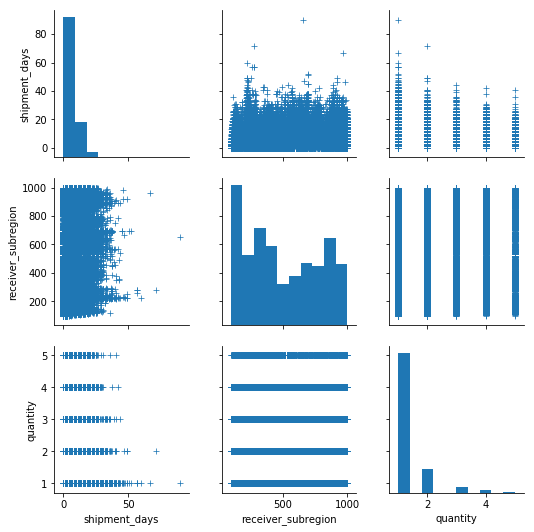

In [ ]:
plt.figure(figsize=(10, 6))

sns.pairplot(
    data=dataset,
    vars=['shipment_days', 'receiver_subregion', 'quantity'],
    markers='+')
plt.title('')
sns.despine()

De los gráficos anteriores no se pueden sacar conclusiones sobre la existencia de posibles correlaciones. Por lo tanto, se seguirá explorando con otras opciones.

In [ ]:
plt.figure(figsize=(10,6))
sns.jointplot(data=dataset,
                  x='shipment_days', y='receiver_subregion', kind='kde')


In [ ]:
minor_shipment_days = dataset['receiver_subregion'].between(100,200,inclusive=True)
dataset[minor_shipment_days]['receiver_state'].value_counts(normalize=True)

En el gráfico anterior se puede ver que para los valores de **receiver_subregion** entre 100 y 200 se tiene una alta concentración de valores bajos de **shipment_days**. Al consultar los estados asociados a dichos valores de **receiver_subregion**, encontramos que la mayoría son de SP, por lo que era de esperar que tuviera tiempos de envío bajos.

In [ ]:
plt.figure(figsize=(15,6))
data = dataset[['quantity', 'shipment_days']]
data = data.pivot_table(index='quantity', columns='shipment_days', aggfunc=len, fill_value=0)
sns.heatmap(data,cmap='Greens')
sns.despine()

La interpretación de este gráfico puede darse a confusión, puesto que el peso de la cantidad de envíos sobre el total de envíos es un factor importante para graficar. De todas maneras, se puede observar que, de los envíos con menor tiempo, la mayoría tenían valores de quantity 1.

In [ ]:
plt.figure(figsize=(15,8))
data = dataset[['receiver_state', 'shipment_days']]
data = data.pivot_table(index='receiver_state', columns='shipment_days', aggfunc=len, fill_value=0)
sns.heatmap(data,cmap='Greens')
sns.despine()

La interpretación de este gráfico puede darse a confusión, puesto que el peso de la cantidad de envíos sobre el total de envíos es un factor importante para graficar. De todas maneras, se puede observar que son muy frecuentes los envíos que demoran un día y se dirigen hacia SP.

## Análisis de distancias

En esta sección analizaremos las distancias teniendo en cuenta la siguiente consigna (**Pregunta n°7**):

Además del cálculo de los estadísticos correspondientes, sería interesante observar un gráfico que muestre la información estadística (por ejemplo, la media) y la presencia de outliers del número de días que tardan los envíos que se realizan a los diferentes estados de Brasil. ¿Cuál es el estado que, en promedio, tiene una mayor demora? ¿Cuál es la distancia geográfica de San Pablo a dicho estado? ¿Y al de menor?.

Vamos a considerar la distancia (expresada en Km.) entre San Pablo y otro estado, como la distancia entre las capitales de los estados, tal como lo generamos y calculamos en la información de estados provista:



In [ ]:
state_basic_cols = ['id','name','distance'] 
brazil_states[state_basic_cols].sort_values('distance', ascending=True)

!["Distancias consideradas"](./02_distancias.png)

Si bien esta distancia es, por definición, un poco burda, creemos que es información valiosa en términos de distancias y que sería interesante estudiar si hay alguna relación entre los tiempos de envíos y las distancias a los estados. Ordenaremos los estados decrecientemente, por tiempos medios de envíos:

In [ ]:
shipments_by_state = dataset.groupby('receiver_state')['shipment_days'].mean().reset_index()
shipments_by_state = pd.merge(brazil_states[state_basic_cols],
                              shipments_by_state,
                              left_on='id',
                              right_on='receiver_state',
                              how='left').drop('id',axis=1)
shipments_by_state = shipments_by_state[['name','receiver_state','distance','shipment_days']]
shipments_by_state.sort_values(['distance','shipment_days'], ascending=False)

Los resultados no están ordenados de la misma forma, pero se aprecia claramente una relación entre las dos variables: los envíos que están más cerca (de nuevo, para una definición burda de "cerca"), tardan en promedio menos.

Grafiquemos la relación entre envíos y estados:

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data=dataset,
                x='receiver_state', 
                y='shipment_days',
                whis=2.5, fliersize=8)
plt.xlabel('')
plt.grid(True)
plt.ylabel('Shipment days')
sns.despine()

Puede verse en la mayoría de los estados, outliers en los tiempos de entrega (hacia el lado de mayor tiempo de entrega, claro está). Esto seguramente sea una de las razones por las cuales sea necesaria una estimación de estos valores. Dicho de otro modo, es posible que de no existir estos outliers, la necesidad de estimar la llegada de un paquete no sería parte de una problemática de estimación sino más bien de seteo de reglas.

Por último, uniremos la información de distancias al dataset para graficar la correlación entre las distancias de los estados y el tiempo de envío.

In [ ]:
dataset = pd.merge(dataset,
                   brazil_states[['id','distance']],
                   left_on='receiver_state',
                   right_on='id',
                   how='left').drop('id',axis=1)

In [ ]:
plt.figure(figsize=(10,6))
sns.jointplot(data=dataset,
                  x='shipment_days', y='distance', kind='kde')

Tal como esperábamos, en el gráfico se puede encontrar una alta concentración de valores bajos en distancia y tiempo de envío. Por lo tanto, se puede pensar que es muy probable que los envíos que sean de distancias cortas demoren poco tiempo.

## Análisis de la hora del día de entrega

En esta última sección de análisis de los datos queremos responder la siguiente pregunta (**Pregunta n°8**):

¿Cuál es la distribución de la entrega de envíos por hora del día para cada uno de los estados de Brasil? Realizar un único gráfico donde se muestre esta información.

Graficaremos en primer lugar la distribución de entregas por hora para todos los envíos:



In [ ]:
plt.figure(figsize=(14,5))
dataset['date_visit'].dt.hour.value_counts(normalize=True,sort=False).plot(kind='bar')
plt.grid(True)

Hay datos de entregas (o carga de información de las mismas) para todas las horas del día.
En "horario de oficina" se da la mayoría de las entregas, mayormente en el segmento de las 13 a las 16 horas (y entre las 9 y las 17 abarcando la mayor parte de los envíos)

In [ ]:
dataset['date_visit_hour']=dataset['date_visit'].dt.hour


plt.figure(figsize=(15,8))
data = dataset[['receiver_state', 'date_visit_hour']]
data = data.pivot_table(index='receiver_state', columns='date_visit_hour', aggfunc=len)
sns.heatmap(data,cmap='Greens')
sns.despine()

La interpretación de este gráfico puede darse a confusión, puesto que el peso de la cantidad de envíos sobre el total de envíos es un factor importante para graficar. De todas formas, puede verse que el segmento de 8 a 18 tiene alteraciones en el color por la cantidad de envíos para la mayoría de los estados. Quizá en vez de la cantidad de envíos, tiene más sentido ver la proporción de envíos sobre el total, para un estado dado.

Veamos cómo se comporta cada estado por separado, a través de un boxplot:

In [ ]:
plt.figure(figsize=(14,7))
sns.boxplot(data=dataset,
                x='receiver_state', 
                y='date_visit_hour',
                whis=2.5, fliersize=8)
plt.xlabel('')
plt.grid(True)
plt.ylabel('Shipment hours')
sns.despine()

Se puede ver que en algunos estados las entregas tienen comportamientos de horarios distintos (en Mato Grosso, por ejemplo, los paquetes se entregan más temprano, en Para, Acre y Rio Grande do Norte, por ejemplo, un poco más tarde), pero en el segmento 9 a 16 se atrapan la mayoría de los envíos.

## Inferencia Bayesiana (Consigna n°9)

La inferencia bayesiana está atada, de una manera simplista, a la posibilidad de adivinar con educación (educated guess).

La información con la que contamos (por ejemplo el correo, el tipo de envío y el estado de destino) conforman en nuestro análisis un "a priori" que forma parte de una cota de tiempos de envío mucho más razonable que no formular hipótesis entre los tiempos. Dicho esto, con la información que tenemos en nuestro dataset, podemos ajustar la probabilidad del tiempo de envio entre dos parámetros dados por nuestros datos (experiencia) que serán mucho más probable que decir, por ejemplo, "el envío llegará entre 0 y 1.000.000 de días".

La probabilidad de que un paquete llegue, por ejemplo, cerca de la media de la cantidad de días que tardaron los paquetes anteriores con los que contamos información, es una estimación mucho más valiosa que la mencionada anteriormente.

Con los datos con los que contamos, al calcular la probabilidad de que un paquete (con las características descriptas) llegue en un tiempo dado, estamos generando nueva información para el sistema (estamos incorporando información a el "a posteriori") que junto con la información que recolectemos de la realidad del envío del paquete, harán que contemos con información que nos permita una estimación más precisa de estos tiempos.

De todas formas, tenemos que tener presente también que estamos ante un problema en donde queremos estimar una información. Si cometemos el error de creer que conocemos la respuesta, podemos estar censurando el poder de la información de los datos.

### Conclusiones

En este trabajo analizamos el dataset propuesto por Mercado Libre con el objetivo de estimar **cuando llega un envío** desde que una persona realiza la compra online mediante la plataforma hasta que llega a su casa a través del correo. Algunas de las conclusiones que nos llevamos del análisis de la información se listan a continuación:

* No toda la información del dataset puede considerarse confiable. El dataset inicial tiene una determinada cantidad de datos anómalos (como intervalos de días negativos o fechas que no siguen la cronología esperada). Para cumplir con los objetivos planteados al inicio del trabajo tomamos la decisión de filtrar todos estos valores que no seguian los patrones esperados. En consecuencia, la mayor parte de trabajo se hizo considerando un dataset más reducido.

* La distribución de los códigos postales (de envío y de llegada) parecería seguir una distribución de Poisson. En la distribución de los códigos postales de llegada se observan tres picos que creemos están asociados a los estados de San Pablo, Minas Gerais y Río de Janeiro, esto se concluyo también en un análisis posterior.

* El 80% de los envíos contiene un único producto y los servicios de correo están concentrados en el 0 y 1, que abarcan el 70% de los envíos.

* El estado de San Pablo es el que recibe más envíos, seguido por Minas Gerais y Río de Janeiro.

* San Pablo parecería tener los tiempos de envíos más bajos.

* Las entregas de paquetes se da mayormente entre las 9  y las 16 horas (con una más concentración en el intervalo de 13hs a 17 hs)

* Los envíos en distancias cortas demoran poco tiempo (están correlacionados).